In [8]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Well-5599

In [9]:
df = pd.read_csv('df_5599_cl.csv')

In [10]:
df.head(3)

,Date,Well,Ø_size,Pwh,Twh,ΔP_choke,Qo,Qg
0,2008-06-05,5599,43.418813,67.027297,79.603134,33.538476,5040.47,768018.95
1,2008-08-16,5599,57.231612,73.127587,80.936966,39.569763,5479.40,799524.84
2,2008-08-17,5599,57.284084,72.645848,80.304859,39.113923,5443.61,795277.26


In [11]:
import datetime

df.Date = pd.to_datetime(df.Date)

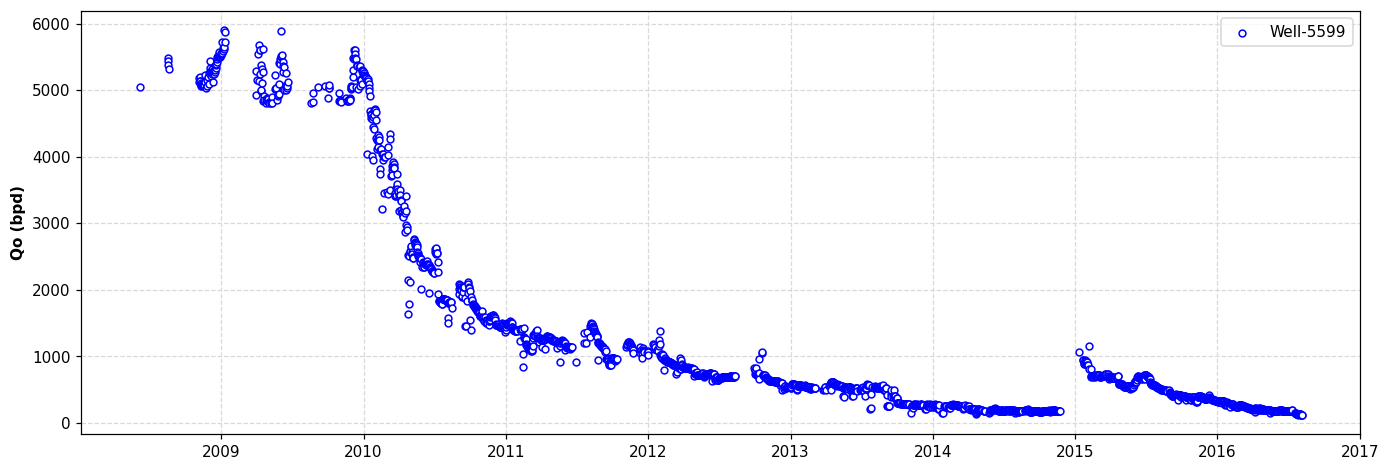

In [12]:
plt.figure(figsize=(15,5), dpi=110)
plt.rc('axes', axisbelow=True)
plt.scatter(df.Date, df.Qo, label='Well-5599', c='white', s=20, edgecolors='blue')
plt.grid(c= (0.85, 0.85, 0.85), linestyle='dashed')
plt.ylabel('Qo (bpd)', fontweight='bold')
plt.legend()
plt.show()

In [13]:
df_filter = df[['Date', 'Ø_size', 'Pwh', 'Twh', 'ΔP_choke']]
df_filter.head(2)

,Date,Ø_size,Pwh,Twh,ΔP_choke
0,2008-06-05,43.418813,67.027297,79.603134,33.538476
1,2008-08-16,57.231612,73.127587,80.936966,39.569763


In [14]:
df_feat = df[['Ø_size','Pwh', 'Twh', 'ΔP_choke']]
df_feat.head(2)

,Ø_size,Pwh,Twh,ΔP_choke
0,43.418813,67.027297,79.603134,33.538476
1,57.231612,73.127587,80.936966,39.569763


In [15]:
df_feat_array = df_feat.to_numpy()
df_feat_array[:3]

array([[43.41881292, 67.02729729, 79.60313417, 33.53847562],
       [57.2316125 , 73.12758729, 80.93696562, 39.5697625 ],
       [57.28408417, 72.64584792, 80.30485854, 39.1139225 ]])

In [16]:
# Splitting Oil & Gas Targets
y_oil = (df['Qo']).to_numpy().reshape(-1,1)
y_gas = np.array(df['Qg']).reshape(-1,1)

In [17]:
# Splitting data into training and test sets
rs = 42
X_train, X_test, y_train_oil, y_test_oil = train_test_split(df_feat_array, y_oil, test_size=0.3,random_state=rs)
X_train, X_test, y_train_gas, y_test_gas = train_test_split(df_feat_array, y_gas, test_size=0.3,random_state=rs)

dates_train, dates_test = train_test_split(df.Date, test_size=0.3, random_state=rs)


In [18]:
# Aplying standardization
from sklearn.preprocessing import StandardScaler

# Defining scalers
sc_feat = StandardScaler()
sc_y_oil = StandardScaler()
sc_y_gas = StandardScaler()

X_train_sc = sc_feat.fit_transform(X_train)
X_test_sc = sc_feat.transform(X_test)
y_train_oil_sc = sc_y_oil.fit_transform(y_train_oil)
y_test_oil_sc = sc_y_oil.transform(y_test_oil)
y_train_gas_sc = sc_y_gas.fit_transform(y_train_gas)
y_test_gas_sc = sc_y_gas.transform(y_test_gas)


### Fitting the model

### 2nd Order Polynomial Regression

In [19]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)
X_train_poly = pf.fit_transform(X_train_sc)
X_test_poly = pf.fit_transform(X_test_sc)

# Fitting the model
plr_oil = LinearRegression()
plr_gas = LinearRegression()
plr_oil.fit(X_train_poly, y_train_oil_sc)
plr_gas.fit(X_train_poly, y_train_gas_sc)

LinearRegression()

In [20]:
# KfoldCV
from sklearn.model_selection import KFold, cross_val_score

folds = KFold(n_splits=8, shuffle=True, random_state=42)
scores = cross_val_score(plr_oil, X_train_poly, y_train_oil_sc, scoring='r2', cv=folds)
print(scores)
print(np.mean(scores))

[0.96965883 0.9627937  0.96887845 0.9752462  0.96010566 0.98068502
 0.94768662 0.96798705]
0.9666301922692255


In [21]:
plr_oil.intercept_

array([0.36248052])

In [22]:
coef = plr_oil.coef_
# np.savetxt('Coeficientes.txt', coef)
coef

array([[ 0.        ,  0.54388825,  1.0645368 , -0.32357339,  0.31979698,
        -0.01512043,  0.34697119, -0.15207103,  0.25162434,  0.74465198,
        -0.13988119, -0.4706615 ,  0.05276276, -0.04127503, -0.18380485]])

In [23]:
# Metrics
# Score & r2_score
y_pred_oil = plr_oil.predict(X_test_poly)
Oil_PLR_Score = round(r2_score(y_test_oil_sc, y_pred_oil),10)

# Mean Absolute Error - MAE
Oil_PLR_MAE = round(mean_absolute_error(y_test_oil_sc, y_pred_oil),3)

# Mean Squared Error - MSE
Oil_PLR_MSE = round((mean_squared_error(y_test_oil_sc, y_pred_oil)),3)

# Root Mean Squared Error - RMSE
Oil_PLR_RMSE = round(np.sqrt(mean_squared_error(y_test_oil_sc, y_pred_oil)),3)

print('R2:', Oil_PLR_Score)
print('MAE:', Oil_PLR_MAE)
print('MSE:', Oil_PLR_MSE)
print('RMSE:', Oil_PLR_RMSE)

R2: 0.97058777
MAE: 0.114
MSE: 0.027
RMSE: 0.163


In [24]:
# Unscaling the variables
y_test_oil_unsc = sc_y_oil.inverse_transform(y_test_oil_sc)
y_pred_oil_unsc = sc_y_oil.inverse_transform(y_pred_oil)
y_pred_oil_unsc[:5]

array([[484.30452942],
       [336.38151406],
       [583.43038686],
       [941.47730223],
       [619.11931443]])

In [25]:
print('R2:', r2_score(y_test_oil_unsc, y_pred_oil_unsc))
print('MAE:', mean_absolute_error(y_test_oil_unsc, y_pred_oil_unsc))
print('MSE:', mean_squared_error(y_test_oil_unsc, y_pred_oil_unsc))
print('RMSE:', np.sqrt(mean_squared_error(y_test_oil_unsc, y_pred_oil_unsc)))

R2: 0.9705877700484321
MAE: 172.50911923131827
MSE: 60516.07074302901
RMSE: 246.0001437866023


In [26]:
df_res = pd.DataFrame({'Date':dates_test, 'y_test_oil':y_test_oil_unsc.ravel(), 'y_pred_oil':y_pred_oil_unsc.ravel()})
df_res.sort_values(by='Date', inplace=True)
df_res.head()

,Date,y_test_oil,y_pred_oil
2,2008-08-17,5443.61,5203.891235
13,2008-11-12,5065.13,4439.265848
20,2008-11-19,5223.41,4655.237657
23,2008-11-25,5062.55,4641.032028
25,2008-11-27,5200.40,5155.070052


In [27]:
#df_res['y_pred_oil'].to_csv('resultados_MPR.csv')

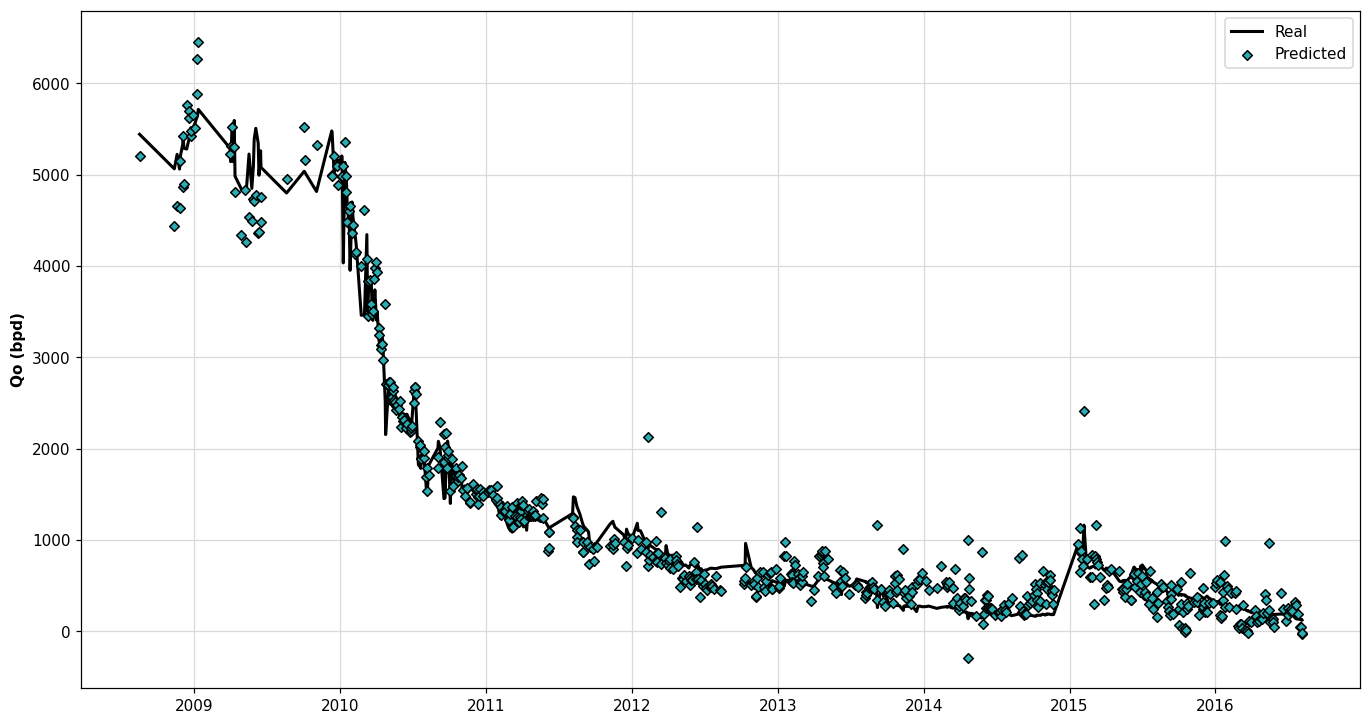

In [32]:
# Plotting real and predicted Oil test datasets
plt.figure(figsize=(15,8), dpi=110)
plt.rc('axes', axisbelow=True)
plt.plot(df_res.Date, df_res.y_test_oil, label='Real', c='black',linewidth=2, zorder=1)
# plt.scatter(X_test['DATEPRD'], y_pred_oil_unsc, label='Predicted', c='blue', s=8)
plt.scatter(df_res.Date, df_res.y_pred_oil,label='Predicted',c='#29ADB2',s=20,marker='D',edgecolors='black',zorder=2)
plt.ylabel('Qo (bpd)', fontweight='bold')
#plt.title('Real vs Predicted Test Dataset Well-5599 (Oil)')
plt.legend()
plt.grid(c=(0.85,0.85,0.85))
plt.show()

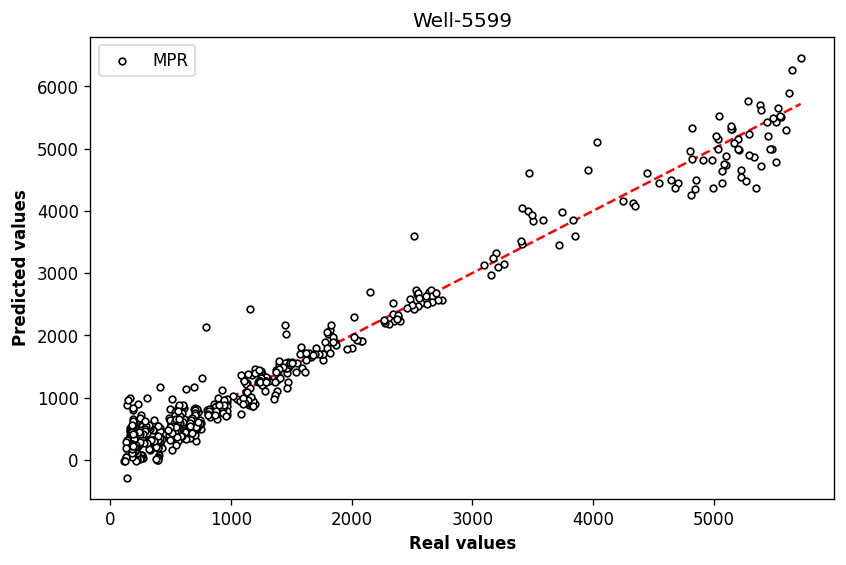

In [22]:
# Plot Actual vs Predicted
plt.figure(figsize= (8,5), dpi=120)
plt.rc('axes', axisbelow=True)
plt.scatter(df_res['y_test_oil'], df_res['y_pred_oil'], label='MPR', c='white', edgecolors='black', s=16)
x_values = (min(df_res['y_test_oil']), max(df_res['y_test_oil']))
y_values = (x_values[0], x_values[1])
plt.plot(x_values, y_values, linestyle='--', c='r', zorder=0)
plt.title('Well-5599')
plt.xlabel('Real values', fontweight='bold')
plt.ylabel('Predicted values', fontweight='bold')
plt.legend()
plt.show()

$ \hat{y} = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \beta_{3}x_3 + \beta_{4}x_{4} + \beta_{5}x_{1}^{2} + \beta_{6}x_{1}x_{2} + \beta_{7}x_{1}x_{3} + \beta_{8}x_{1}x_{4} + \beta_{9}x_{2}^{2} + \beta_{10}x_{2}x_{3} + 
\beta_{11}x_{2}x_{4} + \beta_{12}x_{3}^{2} + \beta_{13}x_{3}x_{4} + \beta_{14}x_{4}^{2} + \epsilon $

$ \hat{y} = 0.362 + 0.544x_{1} + 1.065x_{2} - 0.324x_3 + 0.320x_{4} - 0.015x_{1}^{2} + 0.347x_{1}x_{2} - 0.152x_{1}x_{3} + 0.252x_{1}x_{4} + 0.745x_{2}^{2} - 0.140x_{2}x_{3} - 
0.471x_{2}x_{4} + 0.053x_{3}^{2} - 0.041x_{3}x_{4} - 0.184x_{4}^{2} $

In [33]:
m = plr_oil.intercept_[0]
# np.savetxt('intercept.txt', plr_oil.intercept_[0].reshape(-1,1))
print(m)

0.36248052386107854


In [35]:
coef = plr_oil.coef_
# np.savetxt('Coeficientes.txt', coef)
coef = coef[0][1:].reshape(14, 1)
print(coef)

[[ 0.          0.54388825  1.0645368  -0.32357339  0.31979698 -0.01512043
   0.34697119 -0.15207103  0.25162434  0.74465198 -0.13988119 -0.4706615
   0.05276276 -0.04127503 -0.18380485]]


In [64]:
# np.savetxt('Coeficientes.txt', coef)
X_test_sc[0]

array([ 0.69421683, -0.53801521,  0.96308216, -0.58313314])

In [65]:
# Multiplicacion de matrices
x1, x2, x3, x4 = X_test_sc[0][0], X_test_sc[0][1], X_test_sc[0][2], X_test_sc[0][3]
X_mat = np.array([x1, x2, x3, x4, x1**2, x1*x2, x1*x3, x1*x4, x2**2, x2*x3, x2*x4, x3**2, x3*x4, x4**2]).reshape(1, 14)

array([[ 0.69421683, -0.53801521,  0.96308216, -0.58313314,  0.48193701,
        -0.37349922,  0.66858784, -0.40482084,  0.28946037, -0.51815285,
         0.3137345 ,  0.92752724, -0.56160513,  0.34004426]])

In [67]:
# coef = coef[0][1:].reshape(14, 1)
y_sc = m + X_mat@coef
y_sc

array([[-0.52122654]])

In [69]:
y = y_sc*np.std(y_train_oil) + np.mean(y_train_oil)
print(y)

array([[484.30452942]])

In [70]:
y_pred_oil[0]

array([-0.52122654])

In [71]:
 np.mean(y_train_oil) + y_pred_oil[0]*np.std(y_train_oil)

array([484.30452942])

In [36]:
y_pred_oil_unsc[0]

array([484.30452942])

In [44]:
res = plr_oil.predict(X_test_poly)[0]
print(res)

[-0.52122654]


In [41]:
sc_y_oil.inverse_transform(res.reshape(-1, 1))

array([[484.30452942]])